In [113]:
using JuMP, Gurobi
using Gadfly, Interact

function solveMPC(n,m,A,B,T,x0,xmax,umax)
    mpc = Model(solver=GurobiSolver(OutputFlag=0))
    @defVar(mpc, -xmax <= x[1:n,t=0:T] <= xmax)
    @defVar(mpc, -umax <= u[1:m,t=0:T] <= umax)
    # Link state and control across the horizon
    for t = 0:T-1
        @addConstraint(mpc, x[:,t+1] .== A*x[:,t] + B*u[:,t])
    end
    # Initial conditions
    @addConstraint(mpc, x[:,0] .== x0)
    # Final state
    @addConstraint(mpc, x[:,T] .== 0)
    # Cost
    @setObjective(mpc, Min,
        sum{sum{x[i,t]^2,i=1:n} + sum{u[j,t]^2,j=1:m},t=0:T})
    # Solve the QP
    solve(mpc)
    # Return the control plan
    return getValue(u[:,0])
end

function simulate(n,m,A,B,T,Tmax,x0,xmax,umax)
    x_history = zeros(n,Tmax)
    u_history = zeros(m,Tmax)
    z_history = zeros(Tmax)
    x_t = x0[:]
    for t = 1:Tmax
        u_t = solveMPC(n,m,A,B,T,x_t,xmax,umax)
        x_history[:,t] = x_t
        u_history[:,t] = u_t
        z_history[t] = sumabs2(x_t) + sumabs2(u_t)
        x_t = A*x_t + B*u_t
    end
    return x_history, u_history, z_history
end

simulate (generic function with 2 methods)

Slider{Float64}([Input{Float64}] 1.3,"umax",1.3,0.7:0.1:2.0)

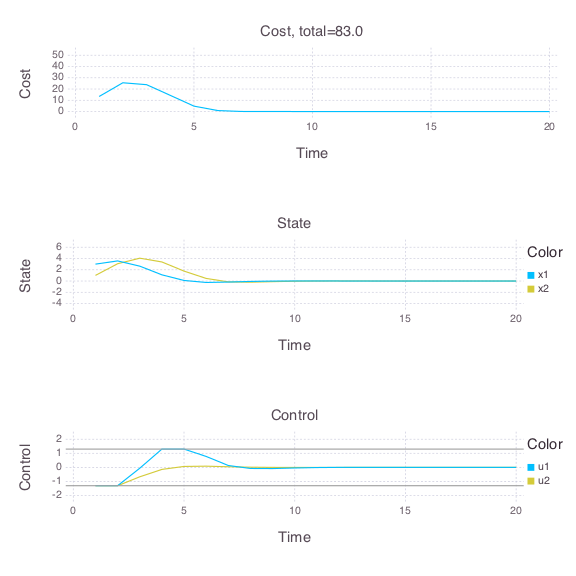

In [136]:
n = 2  # States
m = 2  # Inputs
A = [2.0 -1.0;
     1.0  0.2]  # Dynamics matrix
B = [1.0  0.1;
     0.0  0.1]  # Input matrix
T = 100  # MPC horizon
Tmax = 20  # Length of time we simulate
x0 = [3;1]  # Initial state

# Vary maximum control
@manipulate for umax in 0.7:0.1:2.0
    x,u,z = simulate(n,m,A,B,T,Tmax,x0,10,umax)

    set_default_plot_size(6inch,6inch)
    vstack(
        plot(x=1:Tmax,y=z,Geom.line,
            Guide.xlabel("Time"),Guide.ylabel("Cost"),
            Guide.title("Cost, total=$(round(sum(z)))"),
            Scale.y_continuous(minvalue=0,maxvalue=50)),
        plot(
            layer(x=1:Tmax,y=x[1,:],color=fill(:x1,Tmax),Geom.line),
            layer(x=1:Tmax,y=x[2,:],color=fill(:x2,Tmax),Geom.line),
            Guide.xlabel("Time"),Guide.ylabel("State"),
            Guide.title("State"),
            Scale.y_continuous(minvalue=-4,maxvalue=6)),
        plot(
            yintercept=[-umax,umax], Geom.hline(color="#AAA"),
            layer(x=1:Tmax,y=u[1,:],color=fill(:u1,Tmax),Geom.line),
            layer(x=1:Tmax,y=u[2,:],color=fill(:u2,Tmax),Geom.line),
            Guide.xlabel("Time"),Guide.ylabel("Control"),
            Guide.title("Control"),
            Scale.y_continuous(minvalue=-2,maxvalue=2))
    )
end